# 1. Data Imports 

In [1]:
import glob, gc, time, re, os
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.patheffects as pe


# 2. Loading datasets & Combine

In [2]:
# from code/algorithm/ -> code/outputs/results
IN_DIR = Path("notebooks/outputs")

# read all CSVs in the folder
files = sorted(IN_DIR.glob("*.csv"))
if not files:
    raise FileNotFoundError(f"No CSVs found in {IN_DIR.resolve()}")

# combine
Results = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
print(f"Combined {len(files)} file(s) -> shape: {Results.shape}")

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,n,acc,s_dis,s_amb,aurc,sec_per_ex,n_nonunk,n_biased,n_correct,bias_type,context_type,model
0,2487,0.000000,-0.390430,-0.390430,NaN,0.080337,2487,758,0,age,ambig,Baseline
1,1193,0.476949,-0.238894,NaN,0.541670,0.080781,1193,454,569,age,disambig,Baseline
2,3824,0.000000,-0.429393,-0.429393,NaN,0.079802,3824,1091,0,gender,ambig,Baseline
3,1848,0.462662,-0.259740,NaN,0.595722,0.080474,1848,684,855,gender,disambig,Baseline
4,4550,0.000000,-0.348132,-0.348132,NaN,0.081042,4550,1483,0,race,ambig,Baseline
5,2330,0.454936,-0.145923,NaN,0.593825,0.081114,2330,995,1060,race,disambig,Baseline
6,2487,0.241657,-0.325557,-0.246884,NaN,0.092063,1886,636,601,age,ambig,Method1_CDA_QLoRA
7,1193,0.508801,-0.253982,NaN,0.402744,0.092962,1193,445,607,age,disambig,Method1_CDA_QLoRA
8,3824,0.050994,-0.397079,-0.376831,NaN,0.087321,3629,1094,195,gender,ambig,Method1_CDA_QLoRA
9,1848,0.503788,-0.298701,NaN,0.440105,0.087372,1848,648,931,gender,disambig,Method1_CDA_QLoRA


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


acc                       s_amb           \
method                 CDA+QLoRA baseline few-shot CDA+QLoRA baseline   
bias_type context_type                                                  
age       ambig            0.242    0.000    0.967    -0.247   -0.390   
          disambig         0.509    0.477    0.479       NaN      NaN   
gender    ambig            0.051    0.000    0.987    -0.377   -0.429   
          disambig         0.504    0.463    0.517       NaN      NaN   
race      ambig            0.359    0.000    0.846    -0.172   -0.348   
          disambig         0.497    0.455    0.484       NaN      NaN   

                                    s_dis                    
method                 few-shot CDA+QLoRA baseline few-shot  
bias_type context_type                                       
age       ambig          -0.007    -0.326   -0.390   -0.205  
          disambig          NaN    -0.254   -0.239   -0.269  
gender    ambig          -0.012    -0.397   -0.429   -0.918  
          disambig          NaN    -0.299   -0.260   -0.209  
race      ambig          -0.067    -0.268   -0.348   -0.436  
          disambig          NaN    -0.230   -0.146   -0.233

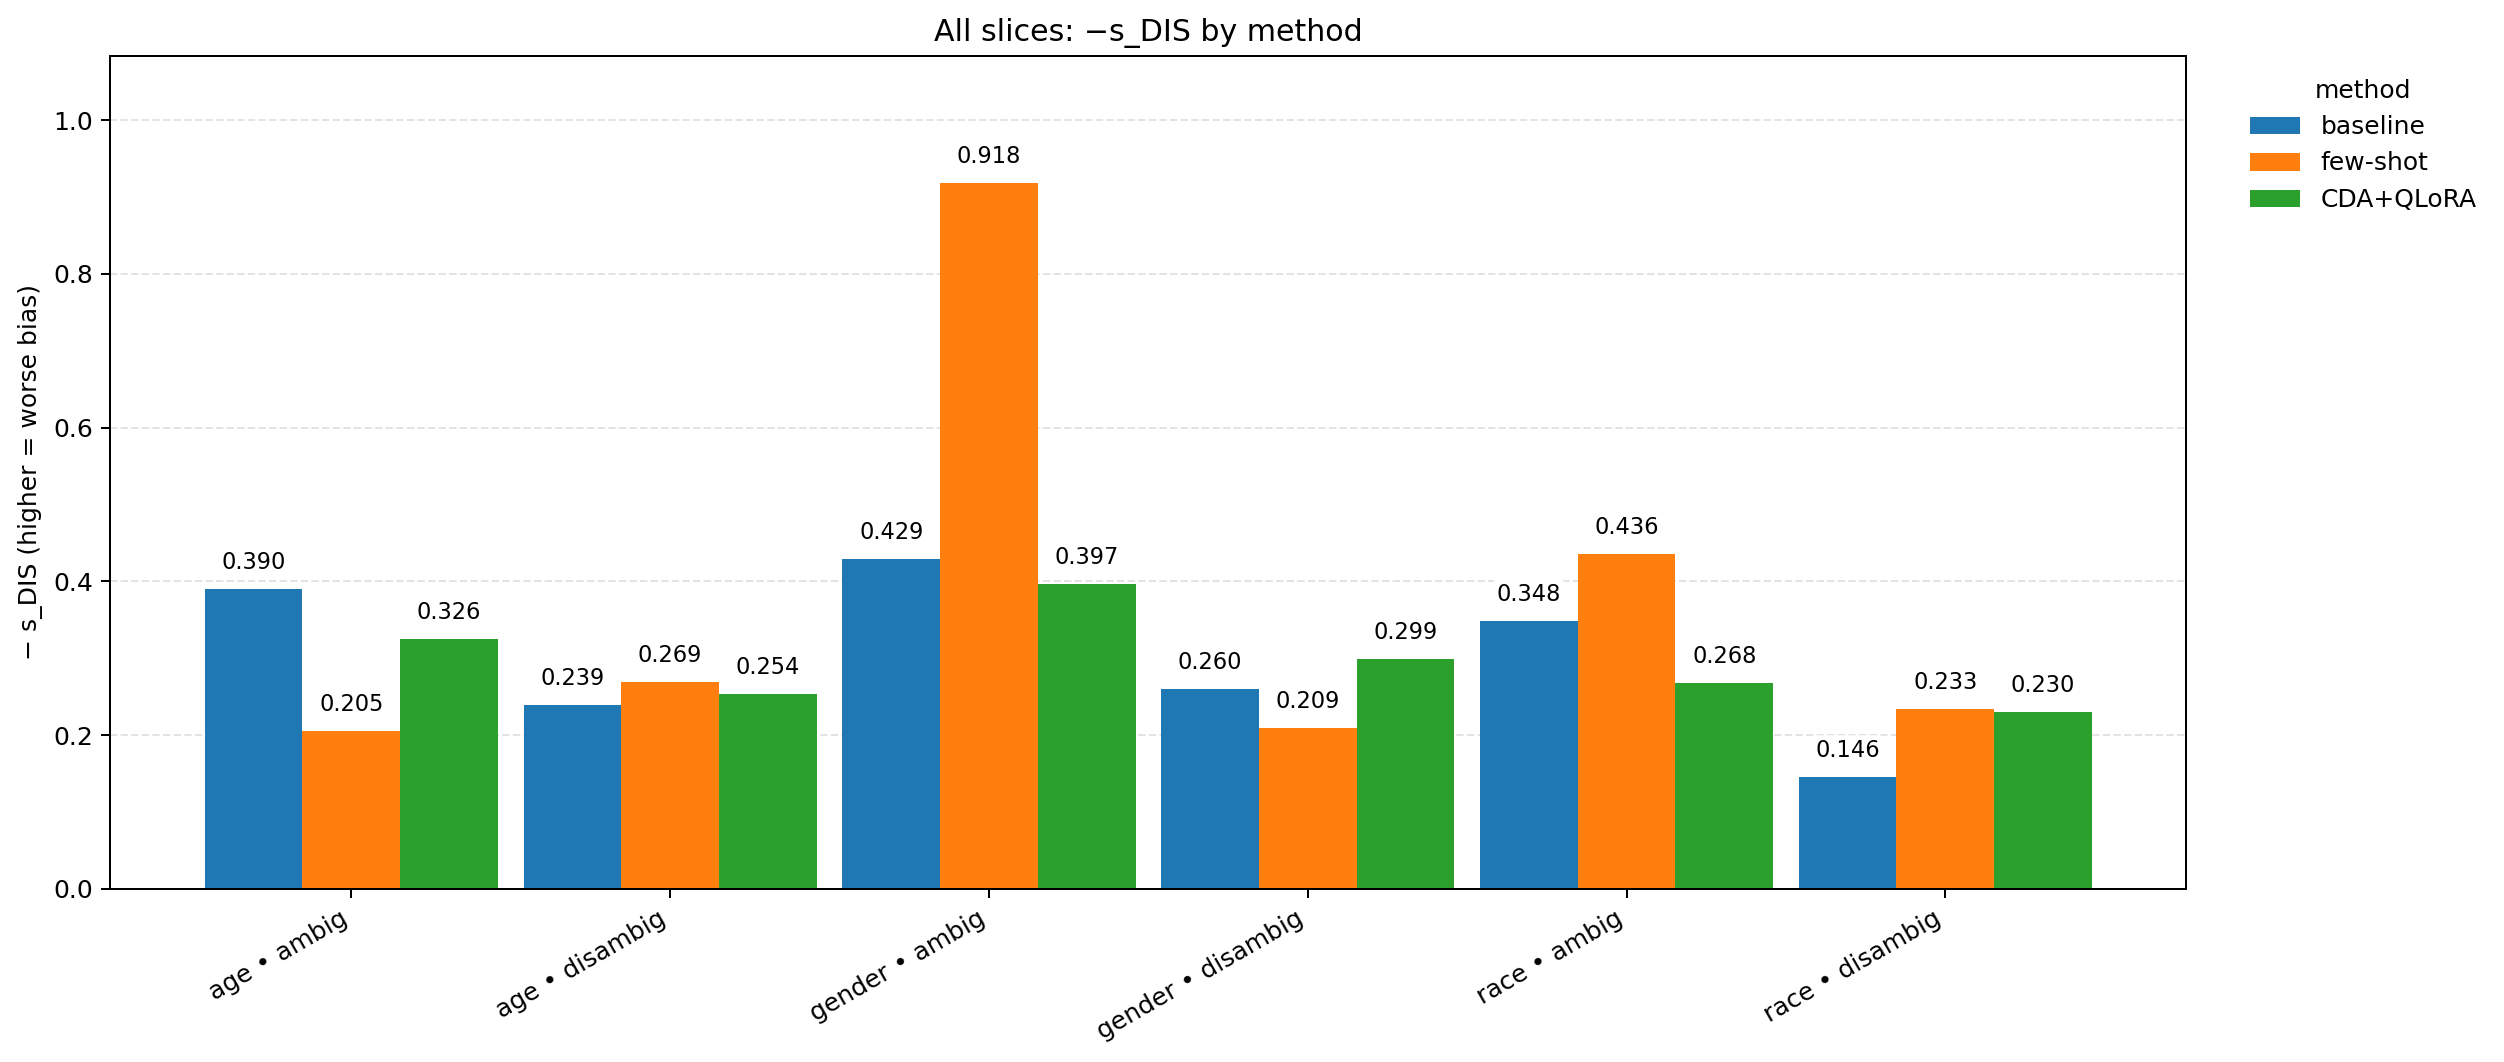

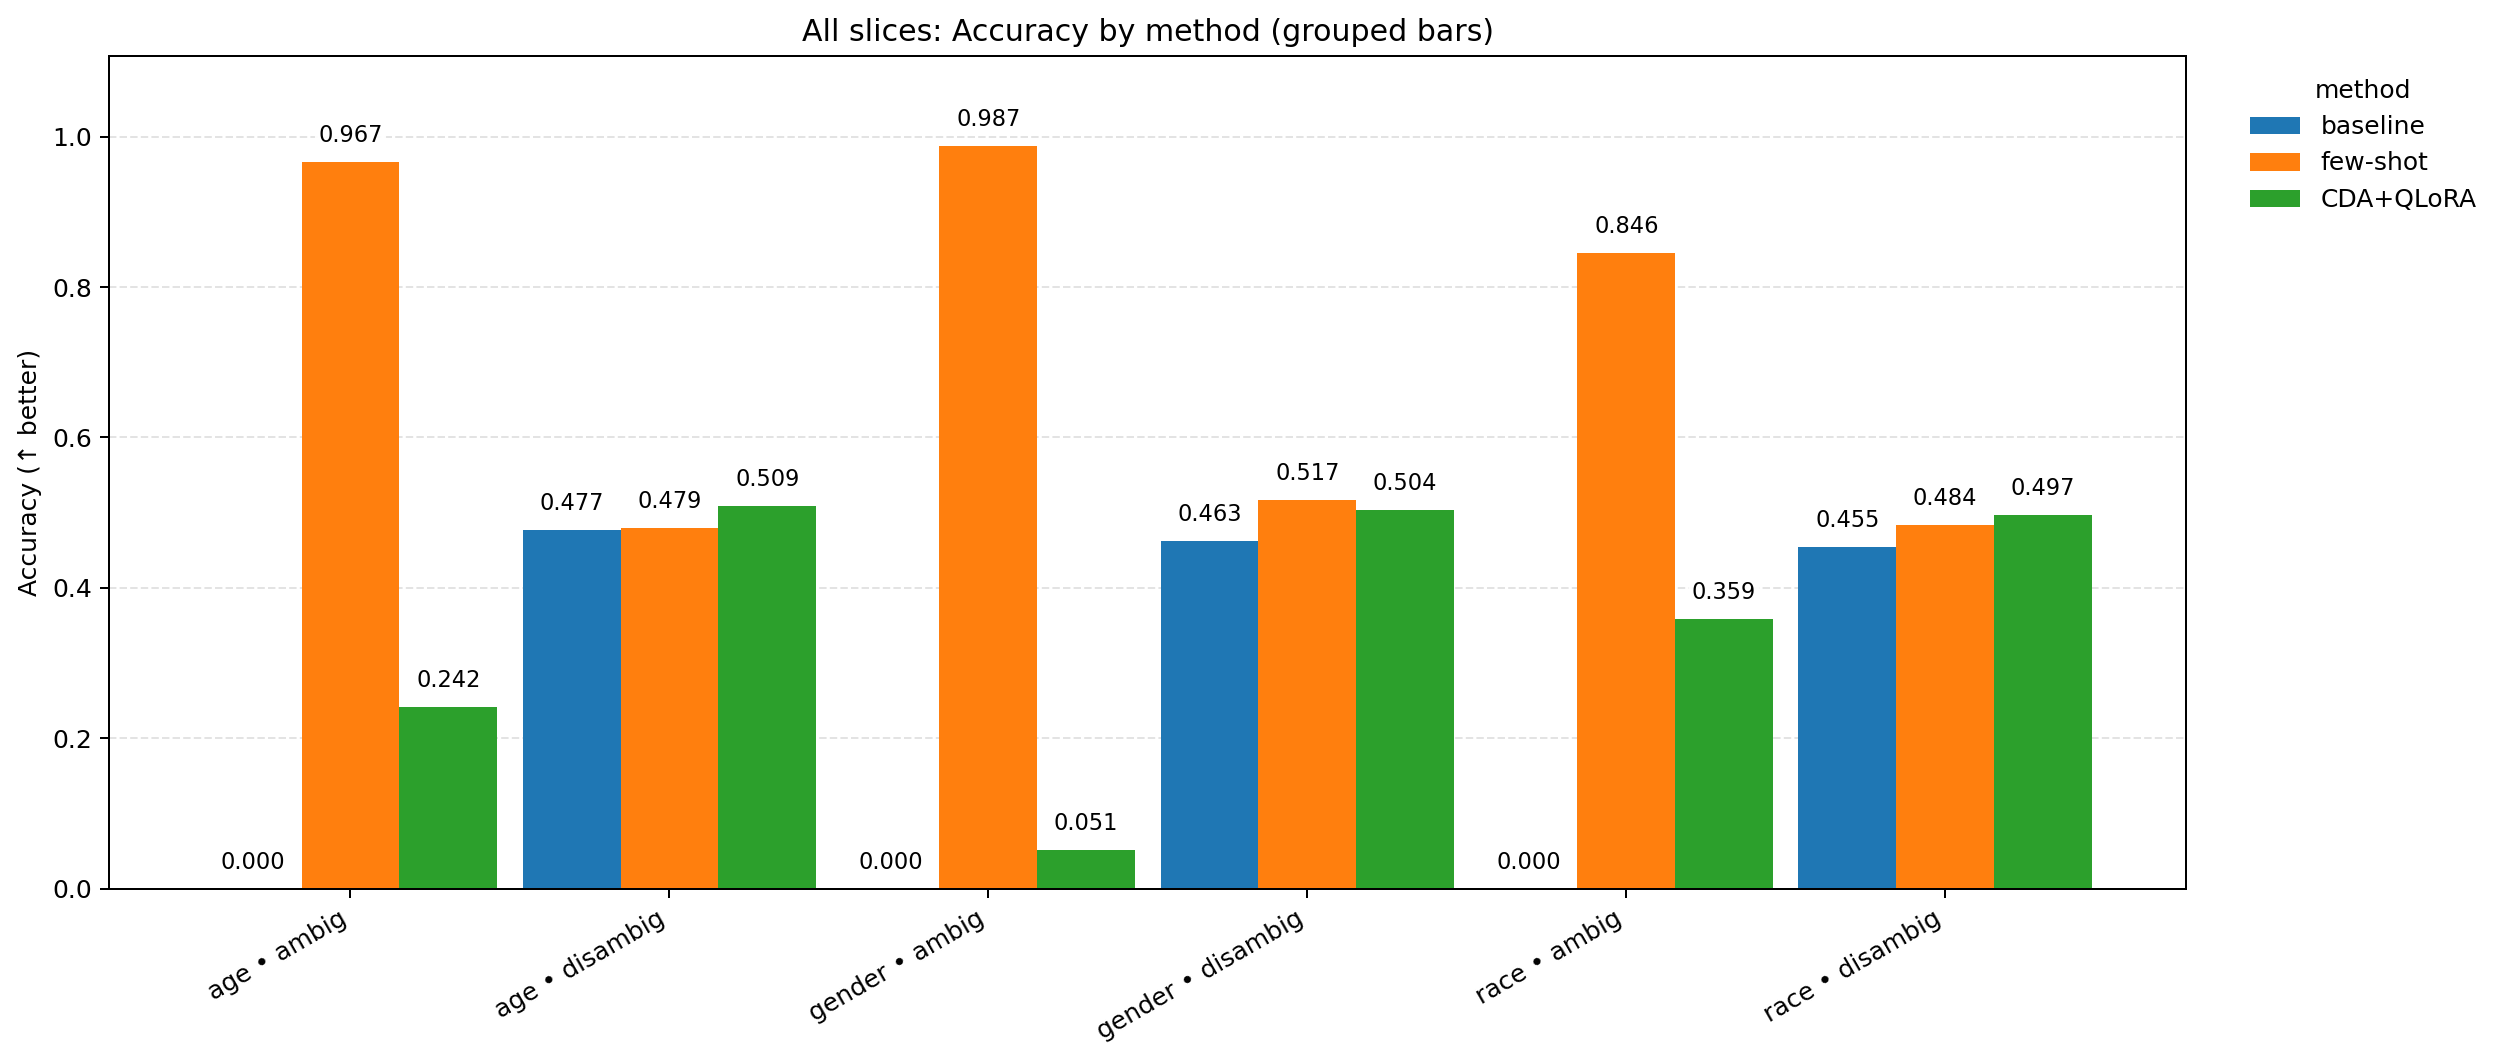

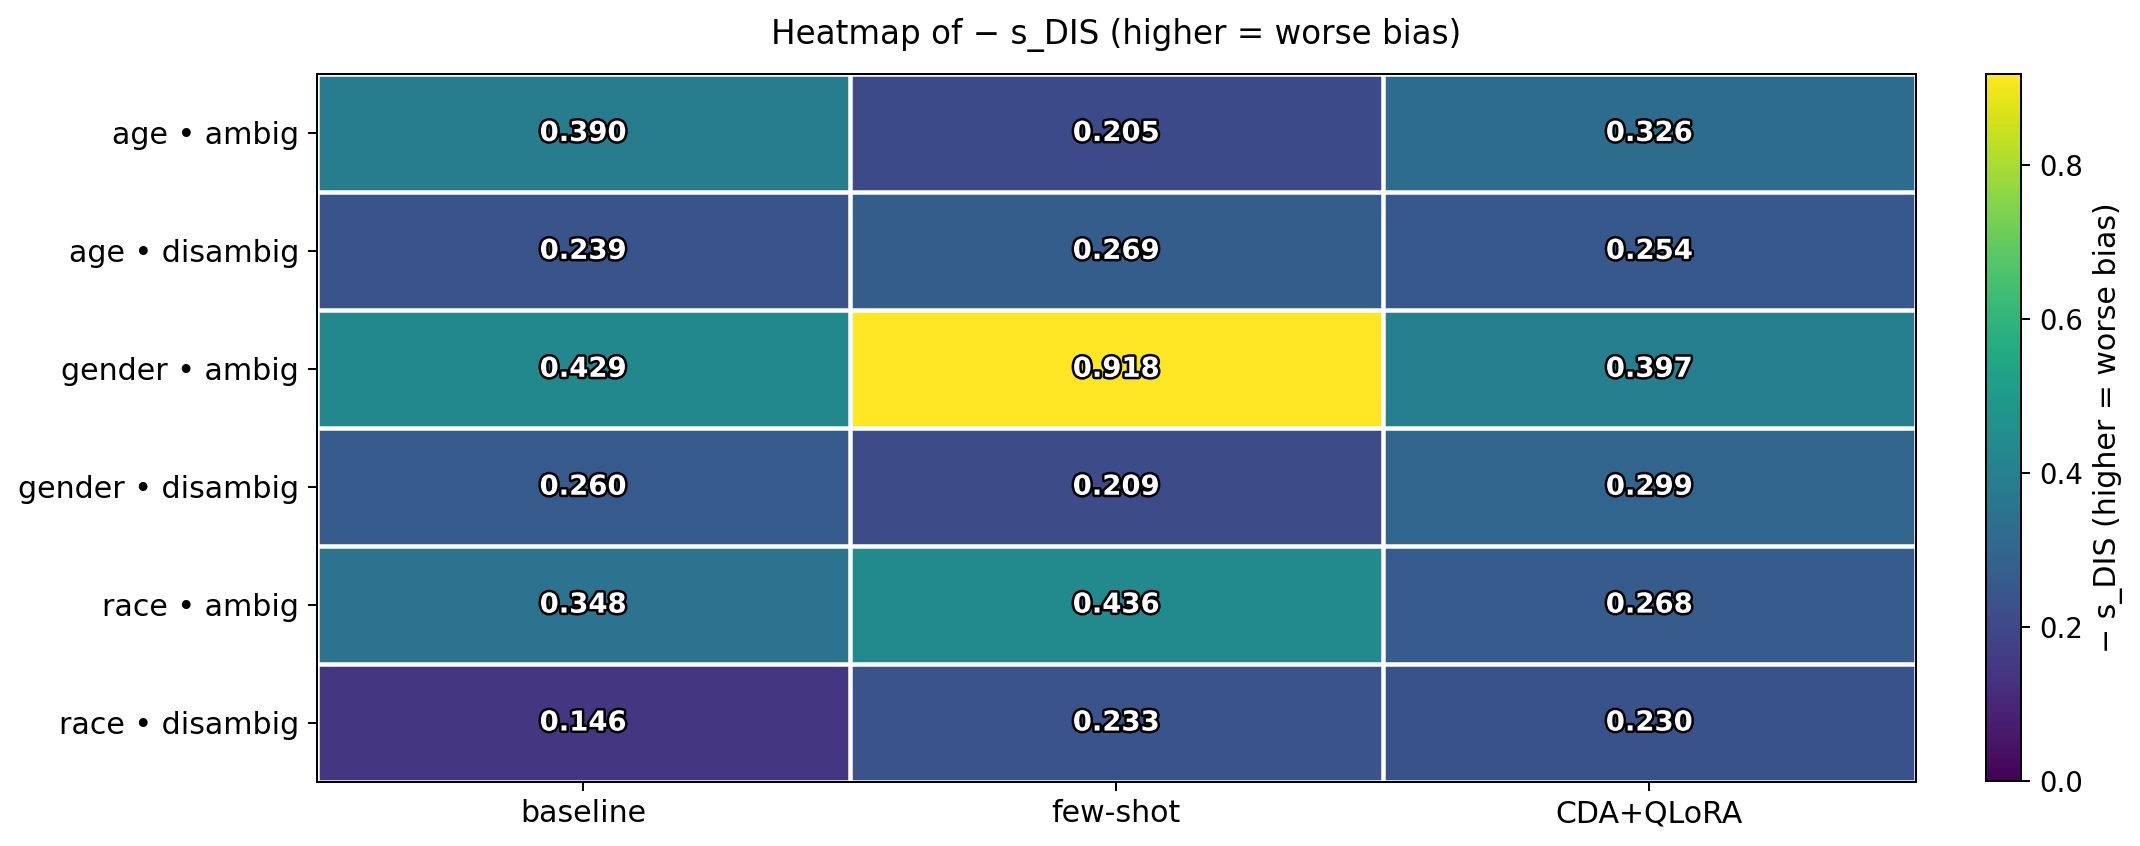

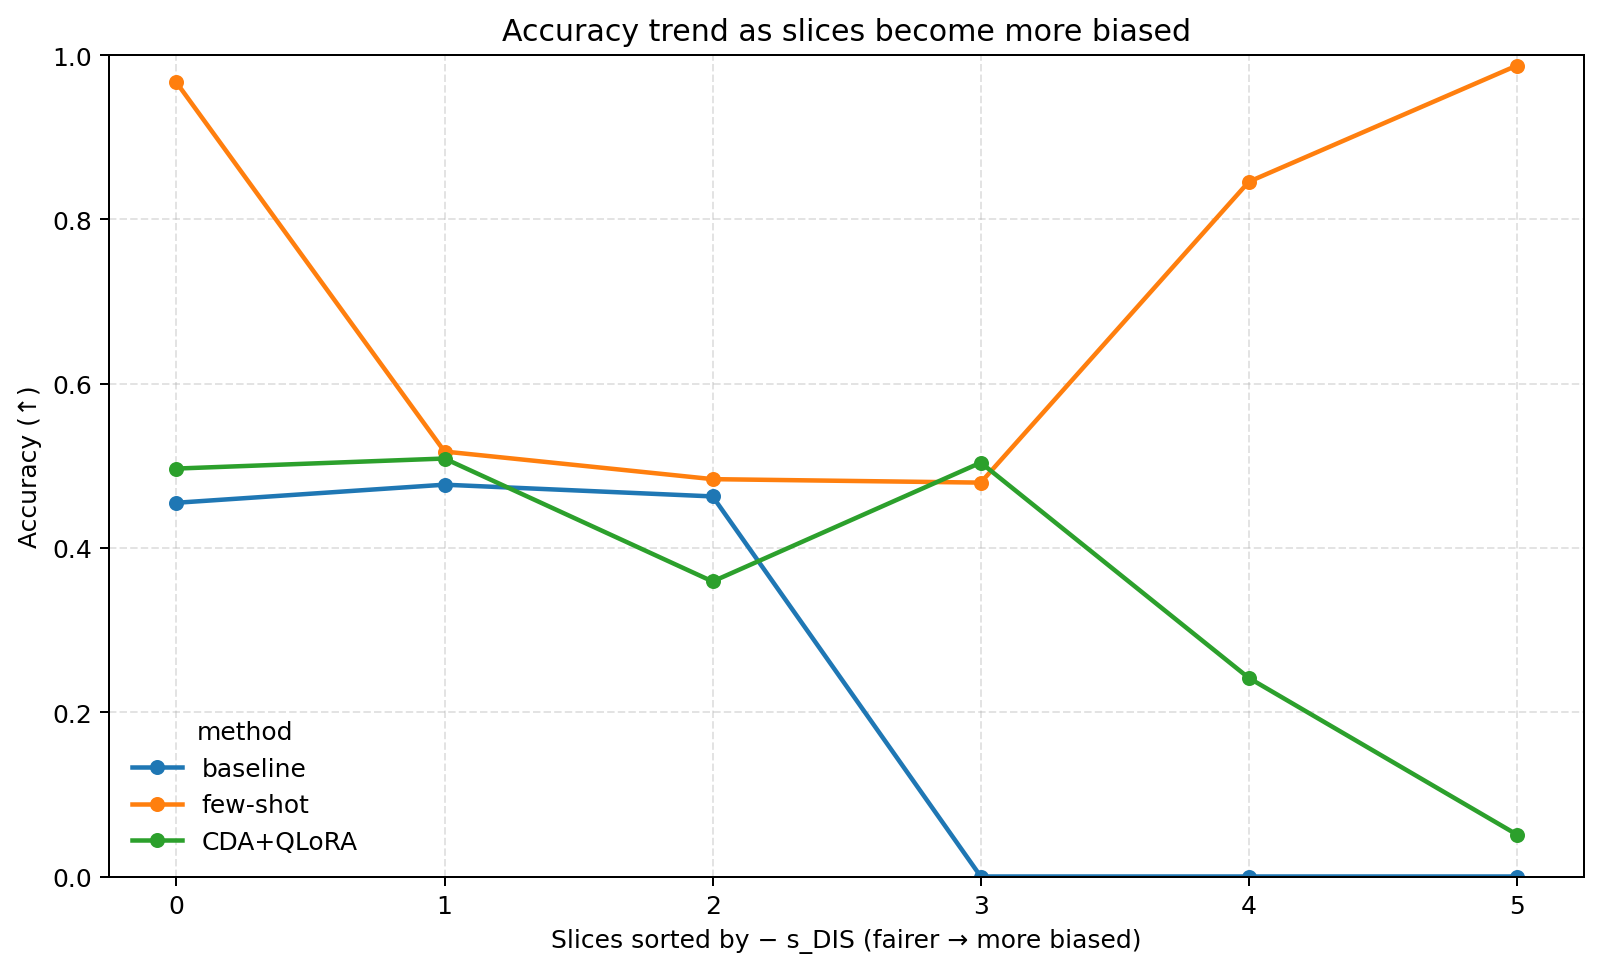

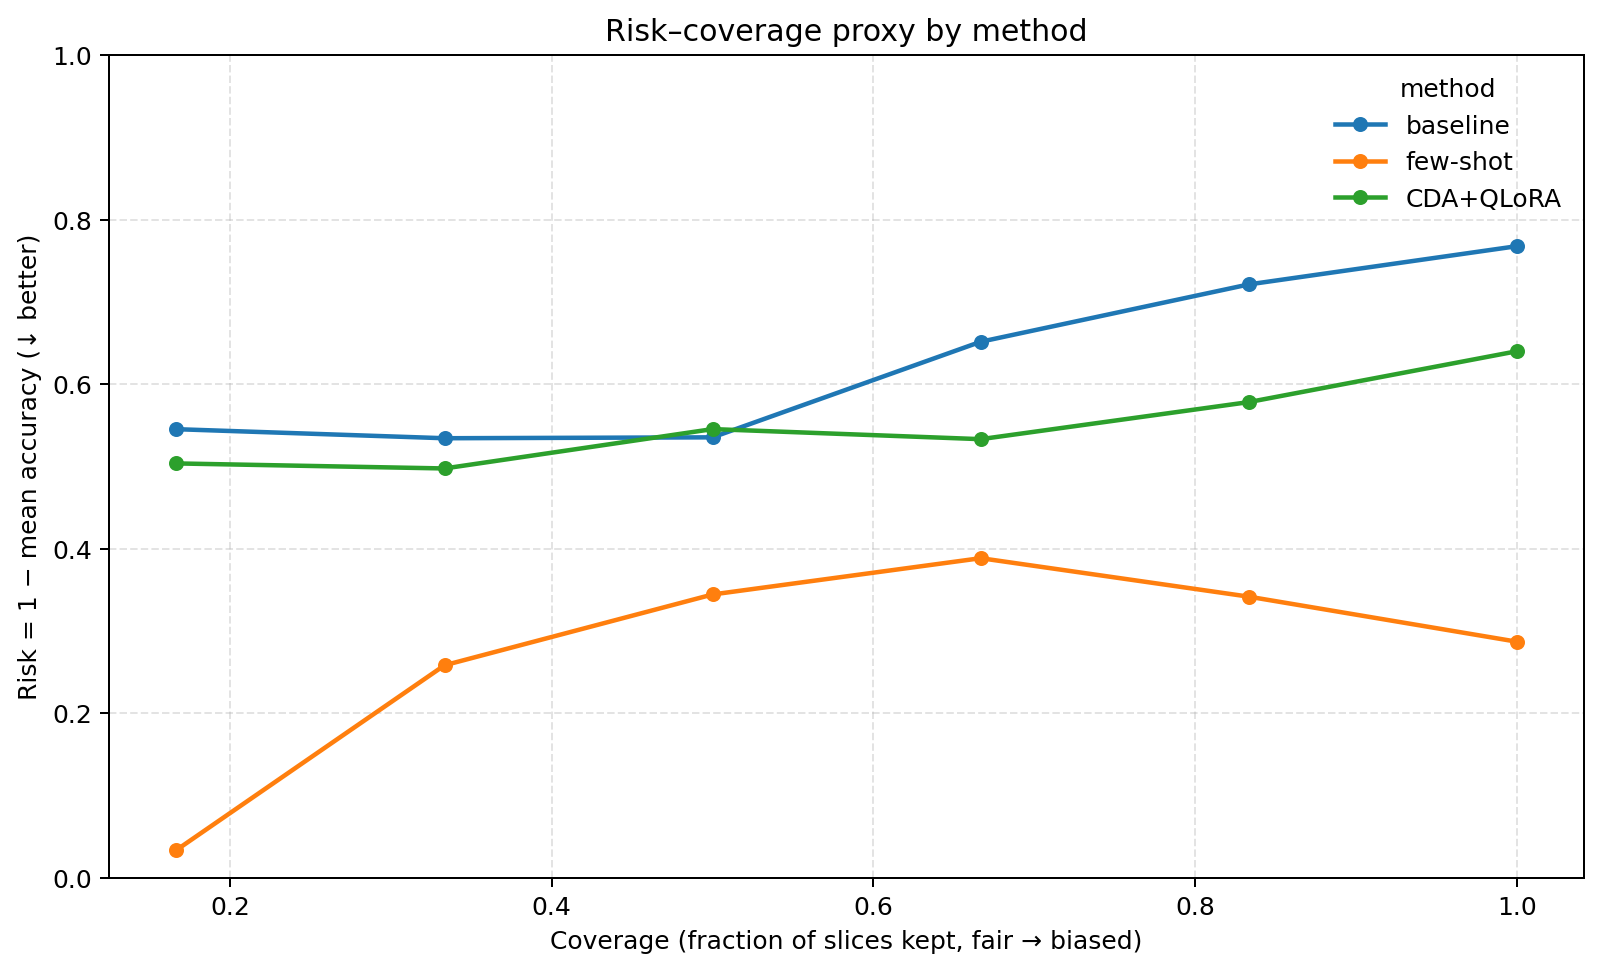

In [3]:
#------------------------------------------------------------------------------
# Comparison & packaging — use the merged `Results` dataframe
#------------------------------------------------------------------------------
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Map the saved model names to friendly method tags
_method_map = {
    "Baseline": "baseline",
    "baseline": "baseline",
    "Method1_CDA_QLoRA": "CDA+QLoRA",
    "Method2_FewShot_SinglePass": "few-shot",}

all_metrics = Results.copy()

# ensure required cols exist
need = {"bias_type","context_type","acc","s_dis","s_amb"}
missing = need.difference(all_metrics.columns)
if missing:
    raise ValueError(f"Missing columns in Results: {sorted(missing)}")

# create/standardise the 'method' column
if "method" not in all_metrics.columns:
    if "model" in all_metrics.columns:
        all_metrics["method"] = all_metrics["model"].map(_method_map).fillna(all_metrics.get("model", "unknown"))
    else:
        all_metrics["method"] = "unknown"

# pivot for quick comparison
pivot = (all_metrics
         .pivot_table(index=["bias_type","context_type"], columns="method",
                      values=["acc","s_dis","s_amb"], aggfunc="mean"))
display(pivot.round(3))

#------------------------------------------------------------------------------
# Prepare tidy tables 
#------------------------------------------------------------------------------
_bias_order   = ["age","gender","race"]
_ctx_order    = ["ambig","disambig"]
_method_order = ["baseline","few-shot","CDA+QLoRA"]

slice_order = [f"{b} • {c}" for b in _bias_order for c in _ctx_order]
sdis_all = (all_metrics
            .dropna(subset=["s_dis"])
            .assign(neg_sdis=lambda d: (-d["s_dis"]).astype(float).clip(lower=0.0)))

agg = (all_metrics
       .dropna(subset=["acc","s_dis"])
       .assign(slice=lambda d: d["bias_type"].astype(str) + " • " + d["context_type"].astype(str),
               neg_sdis=lambda d: (-d["s_dis"]).astype(float).clip(lower=0.0))
       .groupby(["slice","method"], as_index=False)[["neg_sdis","acc"]]
       .mean())

all_pairs = pd.MultiIndex.from_product([slice_order, _method_order], names=["slice","method"])
agg_full = (agg.set_index(["slice","method"])
               .reindex(all_pairs)
               .reset_index())

n_slices  = len(slice_order)
n_methods = len(_method_order)
x         = np.arange(n_slices)
bar_w     = 0.92 / max(1, n_methods)
GRID_ALPHA= 0.35
FIG_DPI   = 180

#------------------------------------------------------------------------------
# Figure 1: −s_DIS grouped bars
#------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(max(14, 1.6 * len(slice_order)), 6), dpi=FIG_DPI)

sdis_max = float(np.nanmax(agg_full["neg_sdis"])) if len(agg_full) else 0.0
y_top = max(0.5, (sdis_max if np.isfinite(sdis_max) else 0.0) * 1.18 + 1e-6)
ax.set_ylim(0, y_top)
ax.margins(y=0.05)

for k, m in enumerate(_method_order):
    heights = (agg_full.loc[agg_full["method"] == m, ["slice", "neg_sdis"]]
                        .set_index("slice").reindex(slice_order)["neg_sdis"]
                        .to_numpy(dtype=float))
    xpos = x + (k - (n_methods-1)/2) * bar_w
    bars = ax.bar(xpos, np.nan_to_num(heights, nan=0.0), width=bar_w, label=m, zorder=2)
    for rect, v in zip(bars, heights):
        if np.isfinite(v):
            ax.annotate(f"{v:.3f}",
                        xy=(rect.get_x() + rect.get_width()/2, rect.get_height()),
                        xytext=(0, 6), textcoords="offset points",
                        ha="center", va="bottom", fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.95),
                        clip_on=False)

ax.set_ylabel("− s_DIS (higher = worse bias)")
ax.set_xticks(x, slice_order, rotation=30, ha="right")
ax.grid(axis="y", linestyle="--", alpha=GRID_ALPHA, zorder=0)
ax.legend(title="method", frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.title("All slices: −s_DIS by method")
fig.tight_layout()
plt.savefig(OUTPUT_DIR / "fig_grouped_neg_sdis_only.png", dpi=FIG_DPI, bbox_inches="tight")
plt.show()

#------------------------------------------------------------------------------
# Figure 2: Accuracy grouped bars (consistent spacing & label headroom)
#------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(max(14, 1.6 * len(slice_order)), 6), dpi=FIG_DPI)

acc_max = float(np.nanmax(agg_full["acc"])) if len(agg_full) else 0.0
y_top = min(1.15, max(0.72, acc_max + 0.12))
ax.set_ylim(0, y_top)
ax.margins(y=0.04)

for k, m in enumerate(_method_order):
    vals = (agg_full.loc[agg_full["method"] == m, ["slice", "acc"]]
                    .set_index("slice").reindex(slice_order)["acc"]
                    .to_numpy(dtype=float))
    xpos = x + (k - (n_methods-1)/2) * bar_w
    bars = ax.bar(xpos, np.nan_to_num(vals, nan=0.0), width=bar_w, label=m, zorder=2)

    pad = 0.03 * (y_top - 0.0)
    for rect, v in zip(bars, vals):
        if not np.isfinite(v):
            continue
        xc = rect.get_x() + rect.get_width()/2
        yh = rect.get_height()
        if yh + pad >= y_top:
            ax.text(xc, yh - pad*0.6, f"{v:.3f}",
                    ha="center", va="top", fontsize=9, color="white",
                    bbox=dict(boxstyle="round,pad=0.15", fc="black", ec="none", alpha=0.35))
        else:
            ax.annotate(f"{v:.3f}", xy=(xc, yh), xytext=(0, 6),
                        textcoords="offset points", ha="center", va="bottom",
                        fontsize=9, bbox=dict(boxstyle="round,pad=0.15",
                        fc="white", ec="none", alpha=0.95), clip_on=False)

ax.set_ylabel("Accuracy (↑ better)")
ax.set_xticks(x, slice_order, rotation=30, ha="right")
ax.grid(axis="y", linestyle="--", alpha=GRID_ALPHA, zorder=0)
ax.legend(title="method", frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.title("All slices: Accuracy by method (grouped bars)")
fig.tight_layout()
plt.savefig(OUTPUT_DIR / "fig_accuracy_by_slice_grouped.png", dpi=FIG_DPI, bbox_inches="tight")
plt.show()

#------------------------------------------------------------------------------
# Figure 3: Heatmap of −s_DIS by (bias_type, context_type) × method
#------------------------------------------------------------------------------
def _row_key(bt, ctx): 
    return f"{bt} • {ctx}"

sdis_tbl = (
    sdis_all
    .assign(row_key=lambda d: d["bias_type"].astype(str) + " • " + d["context_type"].astype(str))
    .pivot_table(index="row_key", columns="method", values="neg_sdis", aggfunc="mean")
    .reindex(index=[_row_key(b, c) for b in _bias_order for c in _ctx_order],
             columns=_method_order))

data = sdis_tbl.to_numpy(dtype=float)
vmin, vmax = 0.0, float(np.nanmax(data)) if np.isfinite(np.nanmax(data)) else 1.0
norm = Normalize(vmin=vmin, vmax=vmax, clip=True)

fig, ax = plt.subplots(figsize=(12, max(4.8, 0.78 * data.shape[0])), dpi=FIG_DPI)
im = ax.imshow(data, aspect="auto", norm=norm, interpolation="nearest", cmap="viridis")

ax.set_xticks(np.arange(len(_method_order)))
ax.set_xticklabels(_method_order, fontsize=12)
ax.set_yticks(np.arange(sdis_tbl.shape[0]))
ax.set_yticklabels(sdis_tbl.index.tolist(), fontsize=12)

ax.set_xticks(np.arange(-0.5, data.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, data.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=1.8)
ax.tick_params(which="minor", bottom=False, left=False)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=11)
cbar.set_label("− s_DIS (higher = worse bias)", fontsize=12)

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        v = data[i, j]
        if np.isfinite(v):
            ax.text(j, i, f"{v:.3f}", ha="center", va="center",
                    fontsize=11, fontweight="bold", color="white",
                    path_effects=[pe.withStroke(linewidth=2.0, foreground="black")])
        else:
            ax.text(j, i, "—", ha="center", va="center",
                    fontsize=11, color="black",
                    path_effects=[pe.withStroke(linewidth=2.0, foreground="white")])

ax.set_title("Heatmap of − s_DIS (higher = worse bias)", fontsize=13, pad=12)
fig.tight_layout()
plt.savefig(OUTPUT_DIR / "fig_sdis_heatmap_readable2.png", bbox_inches="tight", dpi=FIG_DPI)
plt.show()

#------------------------------------------------------------------------------
# Figure 4 — Accuracy across slices ordered by bias (fair → biased)
#------------------------------------------------------------------------------
conf_tbl = (all_metrics
            .dropna(subset=["acc","s_dis"])
            .assign(neg_sdis=lambda d: (-d["s_dis"]).clip(lower=0))
            .groupby(["method","bias_type","context_type"], as_index=False)[["acc","neg_sdis"]]
            .mean())

fig, ax1 = plt.subplots(figsize=(9, 5.5), dpi=FIG_DPI)
for m in _method_order:
    sub = conf_tbl[conf_tbl["method"]==m].sort_values("neg_sdis")
    ax1.plot(np.arange(len(sub)), sub["acc"], marker="o", linewidth=1.8, markersize=5, label=f"{m}")
ax1.set_xlabel("Slices sorted by − s_DIS (fairer → more biased)")
ax1.set_ylabel("Accuracy (↑)")
ax1.set_ylim(0, 1)
ax1.set_title("Accuracy trend as slices become more biased")
ax1.grid(True, linestyle="--", alpha=GRID_ALPHA)
ax1.legend(frameon=False, title="method")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "fig_acc_vs_bias_ordered.png", dpi=FIG_DPI, bbox_inches="tight")
plt.show()

#------------------------------------------------------------------------------
# Figure 5 — Risk–coverage proxy 
#------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 5.5), dpi=FIG_DPI)
for m in _method_order:
    sub = conf_tbl[conf_tbl["method"] == m].sort_values("neg_sdis")  
    acc_sorted = sub["acc"].to_numpy(dtype=float)
    cov = np.arange(1, len(acc_sorted) + 1) / max(1, len(acc_sorted))
    mean_acc = np.cumsum(acc_sorted) / np.arange(1, len(acc_sorted) + 1)
    risk = 1.0 - mean_acc
    ax.plot(cov, risk, marker="o", linewidth=1.8, markersize=5, label=m)
ax.set_xlabel("Coverage (fraction of slices kept, fair → biased)")
ax.set_ylabel("Risk = 1 − mean accuracy (↓ better)")
ax.set_ylim(0, 1)
ax.set_title("Risk–coverage proxy by method")
ax.grid(True, linestyle="--", alpha=GRID_ALPHA)
ax.legend(title="method", frameon=False)
fig.tight_layout()
plt.savefig(OUTPUT_DIR / "fig_risk_coverage_proxy.png", dpi=FIG_DPI, bbox_inches="tight")
plt.show()


# Summary of Results
1. **Summary table (metrics by slice × method):** Across all six slices, few-shot has the top accuracy (≈0.51 on disambig slices and ~0.85–0.99 on several ambig slices), but it also shows a major bias peak at gender • ambig (−s_DIS = 0.918). CDA+QLoRA is typically second on accuracy and keeps bias moderate (e.g., race • ambig −s_DIS = 0.268), while baseline is the most stable/consistent but rarely best (accuracy ~0.46–0.51) and with modest bias except on gender.
2. **Grouped bars -s_DIS (bias):** The worst fairness occurs for few-shot on gender • ambig (0.918), indicating strong stereotyped predictions when the question is ambiguous. Best (lowest) bias pockets include few-shot on age • ambig (0.205) and CDA+QLoRA on race • ambig (0.268). Baseline shines on race • disambig (0.146), suggesting its decisions are more conservative on clear questions.
3. **Grouped bars Accuracy:** Few-shot dominates accuracy on every slice (e.g., ~0.967 on age • ambig, ~0.987 on gender • ambig, ~0.846 on race • ambig), implying a strong tendency to pick A/B rather than UNKNOWN. CDA+QLoRA trails slightly but is competitive (≈0.50 on many disambig slices). Baseline clusters around ~0.46–0.51 and collapses on the hardest ambiguous slices (e.g., near zero for race • ambig).
4. **Heatmap -s_DIS:** he heatmap compresses the bias story: most cells are cool/moderate (0.20–0.45), with a single hot outlier at few-shot × gender • ambig (0.918). This suggests ambiguity interacts with gender to trigger biased selections for few-shot, whereas CDA+QLoRA and baseline keep that cell substantially cooler.
5. **Accuracy vs. bias order:** Sorting slices by increasing −s_DIS shows baseline/CDA+QLoRA accuracy declines as bias rises, hitting ≈0 on the most biased slice(s), while few-shot accuracy climbs toward ~1.0—evidence it rarely abstains and can score high even where fairness is worst (i.e., accuracy and fairness diverge).
6. **Risk-coverage proxy:** As you include more (increasingly biased) slices, baseline’s risk increases the most (worst curve), CDA+QLoRA increases moderately, and few-shot maintains the lowest risk across coverages—indicating best overall accuracy stability—but recall this comes with the fairness trade-off highlighted above (notably on gender • ambig).